<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [19]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

import warnings
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize']=(15, 8)

from scipy.stats import bernoulli, beta   

In [4]:
# datos

data = pd.read_csv('C:/Users/FX506/6.4-lab_ab_testing/data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# transformacion

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
data.isna()

,userid,version,sum_gamerounds,retention_1,retention_7
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
90184,False,False,False,False,False
90185,False,False,False,False,False
90186,False,False,False,False,False
90187,False,False,False,False,False


In [7]:
data.value_counts()

userid   version  sum_gamerounds  retention_1  retention_7
116      gate_30  3               False        False          1
6632278  gate_40  4               False        False          1
6658202  gate_40  9               False        False          1
6658194  gate_40  1               False        False          1
6658134  gate_40  112             True         False          1
                                                             ..
3347358  gate_40  0               False        False          1
3347337  gate_40  3               False        False          1
3346992  gate_40  185             True         False          1
3346979  gate_30  38              True         True           1
9999861  gate_40  16              False        False          1
Length: 90189, dtype: int64

In [8]:
pd.crosstab(data.version, data.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [10]:
pd.crosstab(data.version, data.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


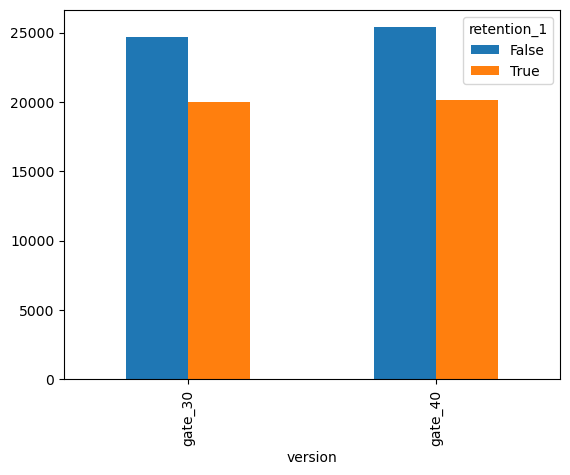

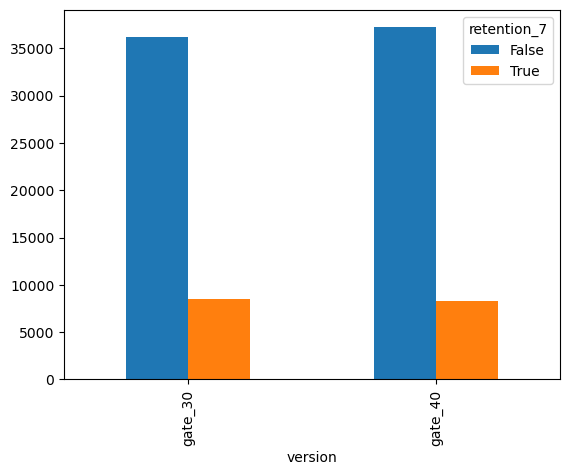

In [11]:
pd.crosstab(data.version, data.retention_1).plot(kind='bar');pd.crosstab(data.version, data.retention_7).plot(kind='bar');

In [13]:
# muestreo

control = data[data.version=='gate_30']

tratamiento = data[data.version=='gate_40']

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9998733,gate_40,10,True,False
90185,9999441,gate_40,97,True,False
90186,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [16]:
# testeo para retention_1

(data['version'] == 'gate_30').value_counts()

False    45489
True     44700
Name: version, dtype: int64

In [17]:
imps_ctrl, convs_ctrl = 44700, 20034    # juegan y los que se quedan

imps_test, convs_test = 45489, 20119 


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [20]:
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [21]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [24]:

from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def f(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def f_iter(a, b, c, d):
    while d > 1:
        d -= 1
        yield f(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(f_iter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.4, lsup=0.5):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

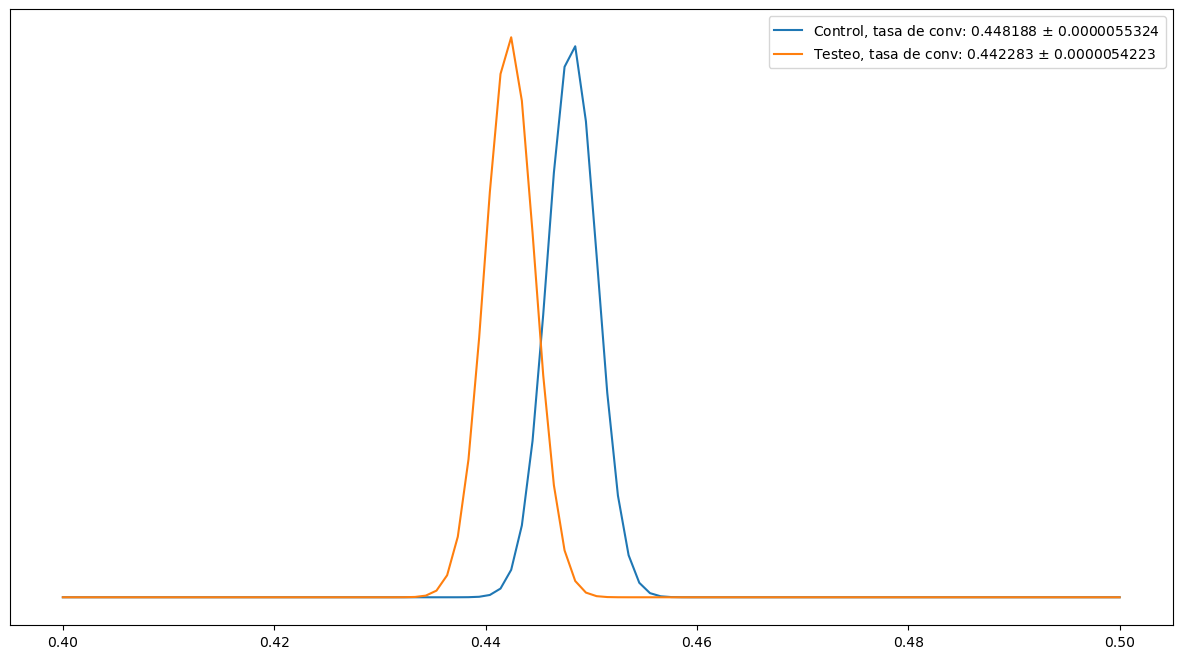

In [25]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [39]:
# testeo para retention_7

imps_ctrl, convs_ctrl = 44700, 8502    # juegan y los que se quedan

imps_test, convs_test = 45489, 8279


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [40]:

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [41]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [42]:

from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def f(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def f_iter(a, b, c, d):
    while d > 1:
        d -= 1
        yield f(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(f_iter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.15, lsup=0.2):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

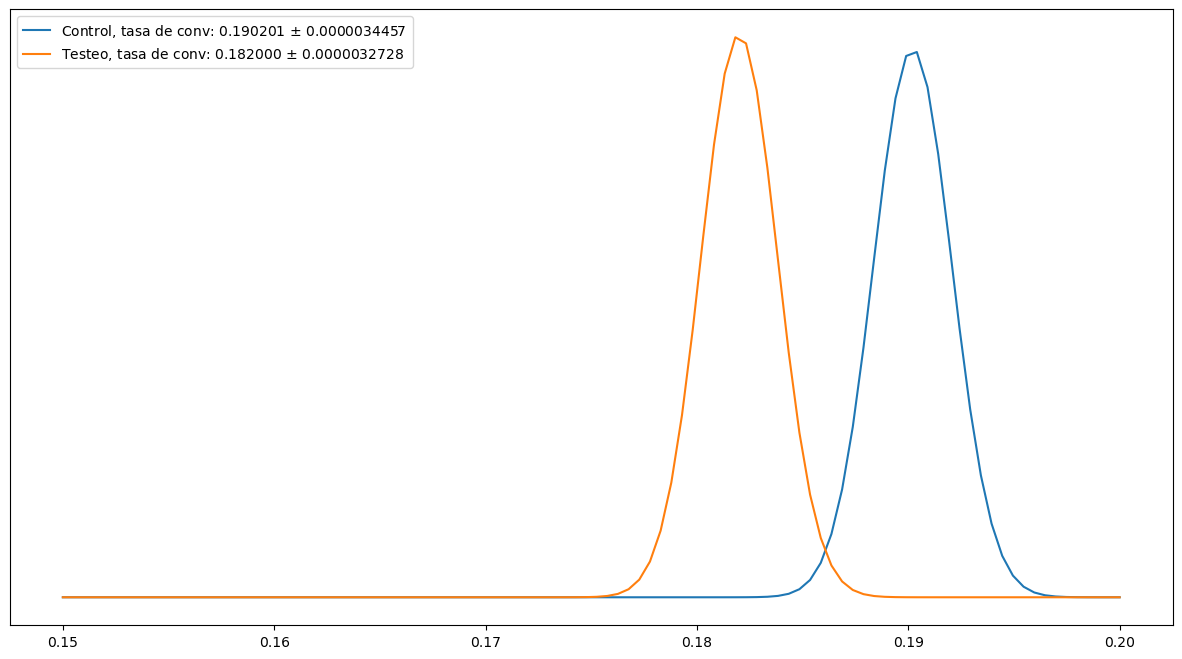

In [43]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

# retencion de 1 dia



# retencion de 1 y 7 dias:

    en vista a la informacion que podemos ver gracias a los tests y graficos, se puede decir que no vale la pena cambiar los gates de 30 a 40 ya que en el testing el
control es ligeramente superior a la version test en ambos casos de retencion (1 dia; 7 dias) y porcentaje de personas que siguen jugando es casi insignificante como para considerar el cambio.